# Run donut cutting on auxTel images with `generateDonutCatalogWcsTask` - is the WCS information good enough now? 

Read in the postISR images

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler

In [2]:
butler = dafButler.Butler('/sdf/data/rubin/repo/main/')
year='2022'
monthDay='0407'

collection='u/scichris/Latiss/DM-37269'
datasetRefOrType = 'postISRCCD'
exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                 'exposure':int(f'{year}{monthDay}00156')
                                    },
                  collections=[collection])
exposure_extra =  butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                 'exposure':int(f'{year}{monthDay}00157')
                                    },
                  collections=[collection])

In [3]:
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (
GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig
)
from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig
)
from lsst.ts.wep.task.CalcZernikesTask import (
    CalcZernikesTask, CalcZernikesTaskConfig)



INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [14]:
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface

For an example of setup, see https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testCalcZernikesCwfsPipeline.yaml and 
    
https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testCalcZernikesLatissPipeline.yaml 
        
an example of using `GenerateDonutCatalogWcsTask` https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/aos/closed_loop/wepSourceSelectionWithWcs.ipynb        

In [138]:
donutDetectConfig = GenerateDonutCatalogWcsTaskConfig()

# Activate the subtask
donutDetectConfig.doDonutSelection = True
# Set flux field
donutDetectConfig.donutSelector.fluxField = 'g_flux'
# Set the magnitude difference for stars to count as not blended with fainter, overlapping stars
#donutDetectConfig.donutSelector.isoMagDiff = 2.0
# Activate magnitude limits
donutDetectConfig.donutSelector.doMagLimit = True
# Set magnitude limits
donutDetectConfig.donutSelector.magMax = 17.
donutDetectConfig.donutSelector.magMin = 7.



# # Activate magnitude limits
# donutDetectConfig.referenceSelector.doMagLimit = True
# # Set the filter to use with the mag limit
# donutDetectConfig.referenceSelector.magLimit.fluxField = 'g_flux'
# # Set magnitude limits
# donutDetectConfig.referenceSelector.magLimit.maximum = 12.
# donutDetectConfig.referenceSelector.magLimit.minimum = 8.

donutDetectTask = GenerateDonutCatalogWcsTask(config=donutDetectConfig)

In [92]:
donutDetectConfig.referenceSelector.magLimit.fluxField?


In [67]:
donutDetectConfig.referenceSelector.magLimit?

In [16]:
# Look at initial configuration
print(donutDetectConfig)
print(donutDetectConfig.keys())

{'saveMetadata': True, 'saveLogOutput': True, 'filterName': 'g', 'referenceSelector': {'doMagLimit': False, 'doFlags': False, 'doUnresolved': False, 'doSignalToNoise': False, 'doMagError': False, 'magLimit': {'minimum': None, 'maximum': None, 'fluxField': 'flux'}, 'flags': {'good': [], 'bad': []}, 'unresolved': {'minimum': None, 'maximum': 0.5, 'name': 'base_ClassificationExtendedness_value'}, 'signalToNoise': {'minimum': None, 'maximum': None, 'fluxField': 'flux', 'errField': 'flux_err'}, 'magError': {'minimum': None, 'maximum': None, 'magErrField': 'mag_err'}, 'colorLimits': {}}, 'donutSelector': {'xCoordField': 'centroid_x', 'yCoordField': 'centroid_y', 'fluxField': 'flux', 'doMagLimit': False, 'magMax': 15.9, 'magMin': 8.74, 'maxFieldDist': 1.813, 'unblendedSeparation': 160, 'minBlendedSeparation': 120, 'isolatedMagDiff': 2.0, 'sourceLimit': -1, 'maxBlended': 0}, 'doDonutSelection': True, 'connections': {'refCatalogs': 'cal_ref_cat', 'exposure': 'postISRCCD', 'donutCatalog': 'donut

In [32]:

# Initialize with pointing information

info = exposure_extra.getInfo()
visitInfo = info.getVisitInfo()
boresightRa, boresightDec = visitInfo.boresightRaDec
boresightRotAng = visitInfo.boresightRotAngle


# boresightRa = 197.464413
# boresightDec = 24.335542
# boresightRotAng = 90.0
refCatInterface = RefCatalogInterface(boresightRa.asDegrees(), 
                                      boresightDec.asDegrees(), 
                                      boresightRotAng.asDegrees())

In [33]:
%%time
htmIds = refCatInterface.getHtmIds()

CPU times: user 179 µs, sys: 201 µs, total: 380 µs
Wall time: 389 µs


In [35]:
%%time
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
butler = dafButler.Butler('/sdf/data/rubin/repo/main/')
catalogName = 'ps1_pv3_3pi_20170110'
collections = ['refcats/DM-28636']
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)

CPU times: user 1.98 s, sys: 317 ms, total: 2.3 s
Wall time: 3.97 s


In [36]:
# The butler dataset references for the pieces of the reference catalog we want
dataRefs[:5]

[DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fed9ac0ba60>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 160034}, id=971a68b9-c847-4198-8e50-764c80cf920f, run='refcats/DM-28636'), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fed9ac0ba60>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 160035}, id=1ef3d9d4-a49d-4ffc-9d66-579bcecafab5, run='refcats/DM-28636'), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fed9ac0ba60>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 160041}, id=092258d1-20c1-4430-b1a0-57c10e7b191e, run='refcats/DM-28636'), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fed9ac0ba60>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, Sim

In [157]:
donutCatalogExtra = donutDetectTask.run(dataRefs, exposure_extra)

INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [156.63955472, 156.78900249], [-30.13688977, -30.00915751] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 635 reference objects
INFO:lsst.generateDonutCatalogWcsTask:Running Donut Selector
INFO:lsst.generateDonutCatalogWcsTask.donutSelector:Selected 8/635 references


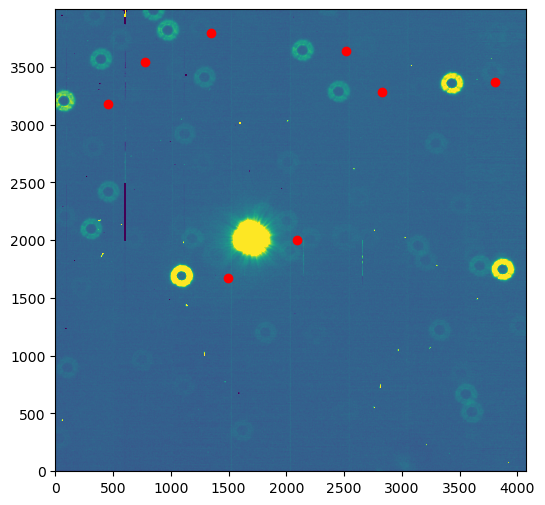

In [158]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
fig = plt.figure(figsize=(12, 6))
data = exposure_extra.getImage().getArray()
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmax=vmax, vmin=vmin, origin='lower')
plt.scatter(donutCatalogExtra.donutCatalog['centroid_x'], 
            donutCatalogExtra.donutCatalog['centroid_y'], c='r')

In [83]:
def flux2ab(flux, unit = 'Jy'):
    """Compute AB mag given flux. 

    Accept two unit types :  
    *  'cgs', meaning flux is in  ergs / s / Hz / cm2
    *  'Jy', meaning flux is in Jy.  1 Jy = 1E-23 * ergs/s/Hz/cm2
    """
    if unit == 'Jy':
        return -2.5 * np.log10(flux) + 8.90
    elif unit == 'cgs':
        return -2.5 * np.log10(flux) - 48.6
    
flux = donutCatalogExtra.donutCatalog['source_flux']

perhaps the star in the middle was too bright to be caught with mag limits 10-15. Try  7-15 : 

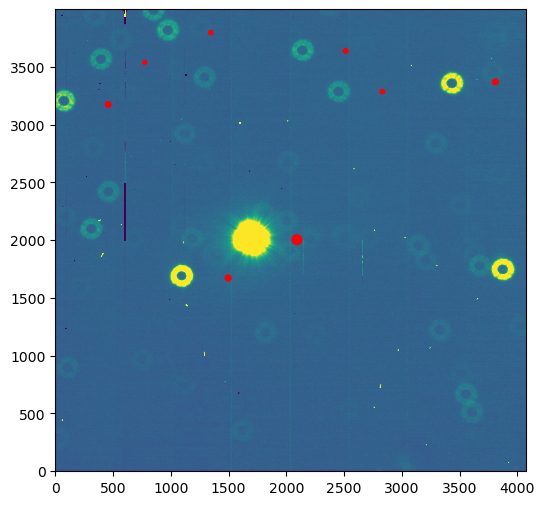

In [141]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
fig = plt.figure(figsize=(12, 6))
data = exposure_extra.getImage().getArray()
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmax=vmax, vmin=vmin, origin='lower')
x = donutCatalogExtra.donutCatalog['centroid_x']
y = donutCatalogExtra.donutCatalog['centroid_y']
flux_nJy = donutCatalogExtra.donutCatalog['source_flux']
flux_Jy = flux_nJy * 1e-9
magAB = flux2ab(flux_Jy)
plt.scatter(x,y , c='r',s=(90-5*magAB))

ok, so we see that the pattern is there, but it's sufficiently off to render the WCS-selection useless (I made the size of the star proportional to the magnitude...).

It appears that the star on the right is actually the one that is the third bright (at x=3900,y=1600...). But I don't find that any simple rotation / flip can fix it .

Also, if I ignore that star on the right, the star pattern appears to be correct, but shifted by about `dx=200px`...

I use functions to move WCS by few px from `AOS_AuxTel_wcs_test.ipynb` : 

In [142]:
def makeNewWcs(wcs, exposure, rotationInDeg, pxOriginShift=[0,0]):
    
    info = exposure.getInfo().getVisitInfo()
    orientation = (info.getBoresightRotAngle().asDegrees()+\
                   rotationInDeg)* lsst.geom.degrees#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  # 
    flipX = True
    scale =  wcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel 
    cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

    # crval  - `lsst.geom.SpherePoint`  Desired reference sky position.
    # crpix = lsst.geom.Point2D(100, 100) - pixel corresponding ot the origin 
    #if pxOriginShift is None:
    
    pxOrigin = wcs.getPixelOrigin()
    
    crpix =  lsst.geom.Point2D(pxOrigin[0]+pxOriginShift[0],
                               pxOrigin[1]+pxOriginShift[1])#lsst.geom.Point2D(2188.5, 2224.5)
    
    crval = wcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
    newWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)
    return newWcs


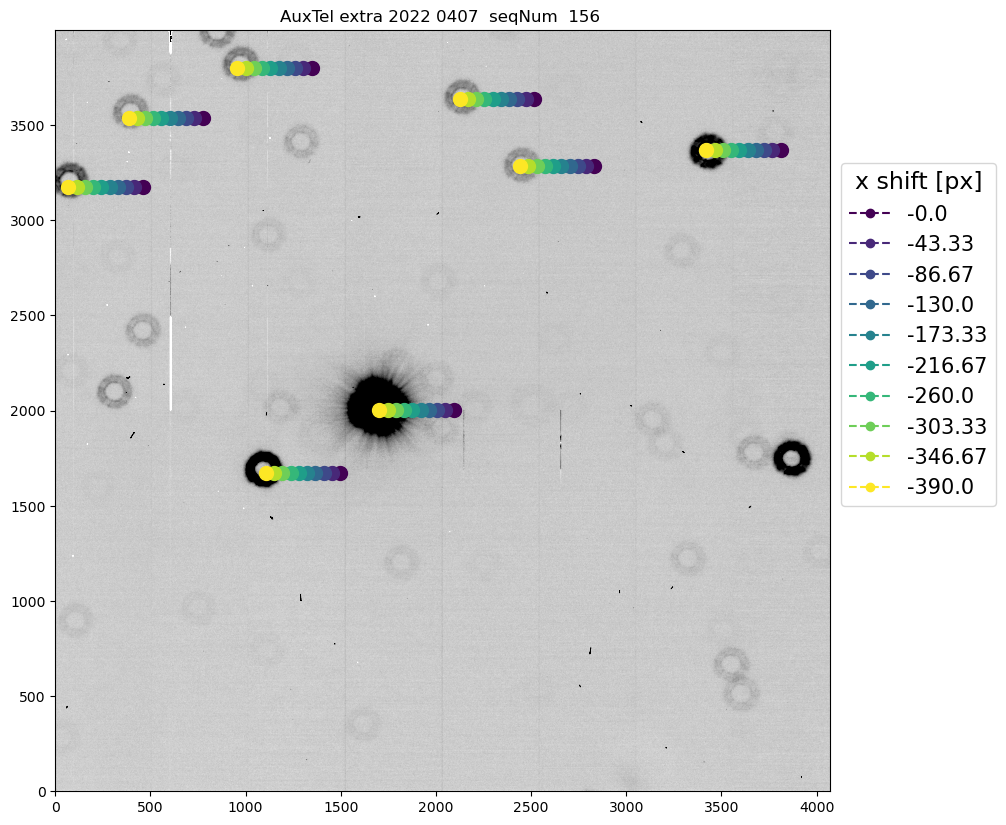

In [156]:
import matplotlib.lines as mlines
data = exposure_extra.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')


ra = donutCatalogExtra.donutCatalog['coord_ra']
dec = donutCatalogExtra.donutCatalog['coord_dec']
i = 0 
shifts =  -np.linspace(0,390,10)
n_dots = len(shifts)
color_idx = np.linspace(0, 1, n_dots)
ax_legend_handles = []
angle = 0

# original WCS 
wcs = exposure_extra.getWcs()

for shift in shifts:
    
    newWcs = makeNewWcs(wcs, exposure_extra, angle, pxOriginShift=[shift,0])
    x,y = newWcs.skyToPixelArray(ra,dec)
    color = plt.cm.viridis(color_idx[i])
    ax.scatter(x,y,s=100,color=color)
    line = mlines.Line2D([], [], color=color, ls='--', marker='o', alpha=1,
                                 label=np.round(shift,2))
    ax_legend_handles.append(line)
    i += 1 
ax.set_title(f'AuxTel extra {year} {monthDay}  seqNum  156 ' )#'='2022'
#monthDay='0407' angle {angle}')
plt.legend(bbox_to_anchor=(1,0.6),title='x shift [px]',
           fancybox=True, loc="center left",
           handles = ax_legend_handles, ncol=1,
          fontsize=15,title_fontsize=17)

So this shows that the WCS attached to the exposure is about 390px off (at least no rotation is needed ).  But this was too far originally to allow donut selector to cut any donuts.  

Even if I correct the WCS "by hand" in that way, I still would have to run `astrometry` using that WCS as `first guess`, and with the new updated WCS,  reload the reference catalog... 